I0000 00:00:1748806688.182475  631853 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1748806688.190709  639447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748806688.194938  639443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748806688.228755  639445 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


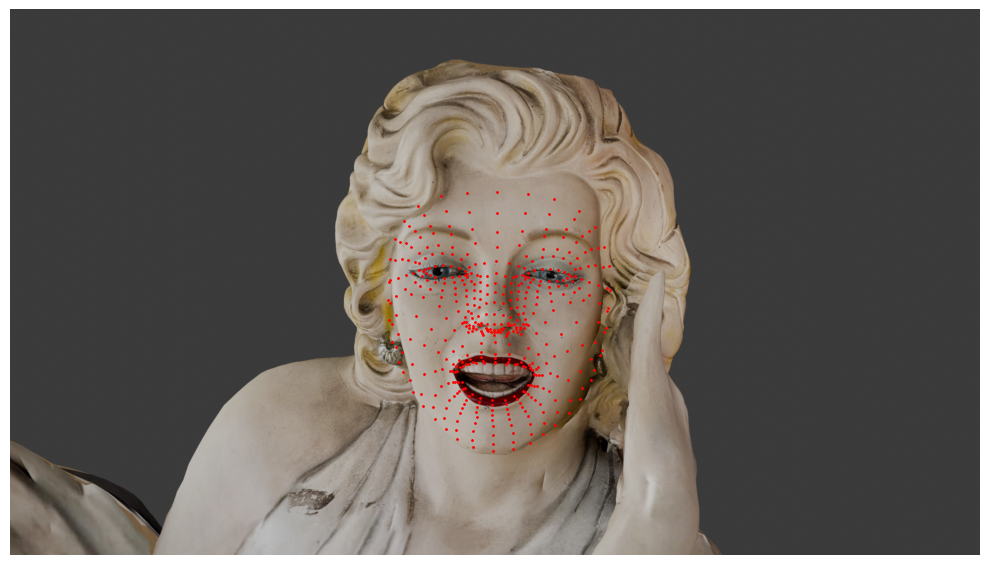

In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# load the face landmark detection model
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# load only the front image
image = cv2.imread("../rotation_5/camera_front.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

results = face_mesh.process(image_rgb)

# draw face landmarks
if results.multi_face_landmarks:
    landmark_coords = []
    for face_landmarks in results.multi_face_landmarks:
        for lm in face_landmarks.landmark:
            x = int(lm.x * w)
            y = int(lm.y * h)
            landmark_coords.append((x, y))

    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    xs, ys = zip(*landmark_coords)
    plt.scatter(xs, ys, s=1, c="red")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
import cv2
import numpy as np
from collections import defaultdict


landmarks = results.multi_face_landmarks[0].landmark

points = np.array([(lm.x * w, lm.y * h, lm.z * w) for lm in landmarks])
verts_fixed = np.array([(x, h - y, -z) for (x, y, z) in points])
centroid = verts_fixed.mean(axis=0)
verts_centered = verts_fixed - centroid

scale = 0.002
verts_scaled = verts_centered * scale

# apply uv coordinates for the texture
uvs = np.array([(lm.x, 1 - lm.y) for lm in landmarks])

# get face meshes provided by the library
edges = set(mp_face_mesh.FACEMESH_TESSELATION)
edges.update(mp_face_mesh.FACEMESH_CONTOURS)
edges.update(mp_face_mesh.FACEMESH_FACE_OVAL)

adj = defaultdict(set)
for start, end in edges:
    adj[start].add(end)
    adj[end].add(start)

triangles = set()
for a in adj:
    for b in adj[a]:
        common = adj[a].intersection(adj[b])
        for c in common:
            tri = tuple(sorted((a, b, c)))
            triangles.add(tri)

# some meshes had to be defined myself
left_eye = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]
right_eye = [
    362,
    382,
    381,
    380,
    374,
    373,
    390,
    249,
    263,
    466,
    388,
    387,
    386,
    385,
    384,
    398,
]
upper_inner_lip = [78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308]
lower_inner_lip = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308]
upper_inner_lip.append(upper_inner_lip[0])
lower_inner_lip.append(lower_inner_lip[0])


# a function to add texture in the eye area
def add_eye_cap(triangles, eye_indices):
    center = eye_indices[0]
    for i in range(1, len(eye_indices) - 1):
        tri = tuple(sorted((center, eye_indices[i], eye_indices[i + 1])))
        triangles.add(tri)


add_eye_cap(triangles, left_eye)
add_eye_cap(triangles, right_eye)


# a function to add texture in the mouth area
def add_lip_bridge(triangles, top_idxs, bottom_idxs):
    min_len = min(len(top_idxs), len(bottom_idxs))
    top_idxs = top_idxs[:min_len]
    bottom_idxs = bottom_idxs[:min_len]
    for i in range(min_len - 1):
        t1 = top_idxs[i]
        t2 = top_idxs[i + 1]
        b1 = bottom_idxs[i]
        b2 = bottom_idxs[i + 1]
        triangles.add(tuple(sorted((t1, b1, b2))))
        triangles.add(tuple(sorted((t1, b2, t2))))


add_lip_bridge(triangles, upper_inner_lip, lower_inner_lip)

triangles = list(triangles)


def write_obj(filename, verts, uvs, faces, texture_filename):
    with open(filename, "w") as f:
        f.write(f"mtllib {texture_filename}.mtl\n")
        f.write("usemtl material_0\n")
        for v in verts:
            f.write(f"v {v[0]:.6f} {v[1]:.6f} {v[2]:.6f}\n")
        for uv in uvs:
            f.write(f"vt {uv[0]:.6f} {uv[1]:.6f}\n")
        for tri in faces:
            f.write(
                f"f {tri[0]+1}/{tri[0]+1} {tri[1]+1}/{tri[1]+1} {tri[2]+1}/{tri[2]+1}\n"
            )


def write_mtl(filename, texture_filename):
    with open(filename, "w") as f:
        f.write("newmtl material_0\n")
        f.write("Ka 1.000 1.000 1.000\n")
        f.write("Kd 1.000 1.000 1.000\n")
        f.write("Ks 0.000 0.000 0.000\n")
        f.write(f"map_Kd {texture_filename}\n")


# save files
texture_image_name = "face_texture.jpg"
cv2.imwrite(texture_image_name, image)

obj_filename = "face_mesh.obj"
mtl_filename = "face_mesh.mtl"

write_obj(obj_filename, verts_scaled, uvs, triangles, mtl_filename)
write_mtl(mtl_filename, texture_image_name)

print(f"OBJ saved: {obj_filename}")
print(f"MTL saved: {mtl_filename}")
print(f"Texture saved: {texture_image_name}")

OBJ saved: face_mesh.obj
MTL saved: face_mesh.mtl
Texture saved: face_texture.jpg
